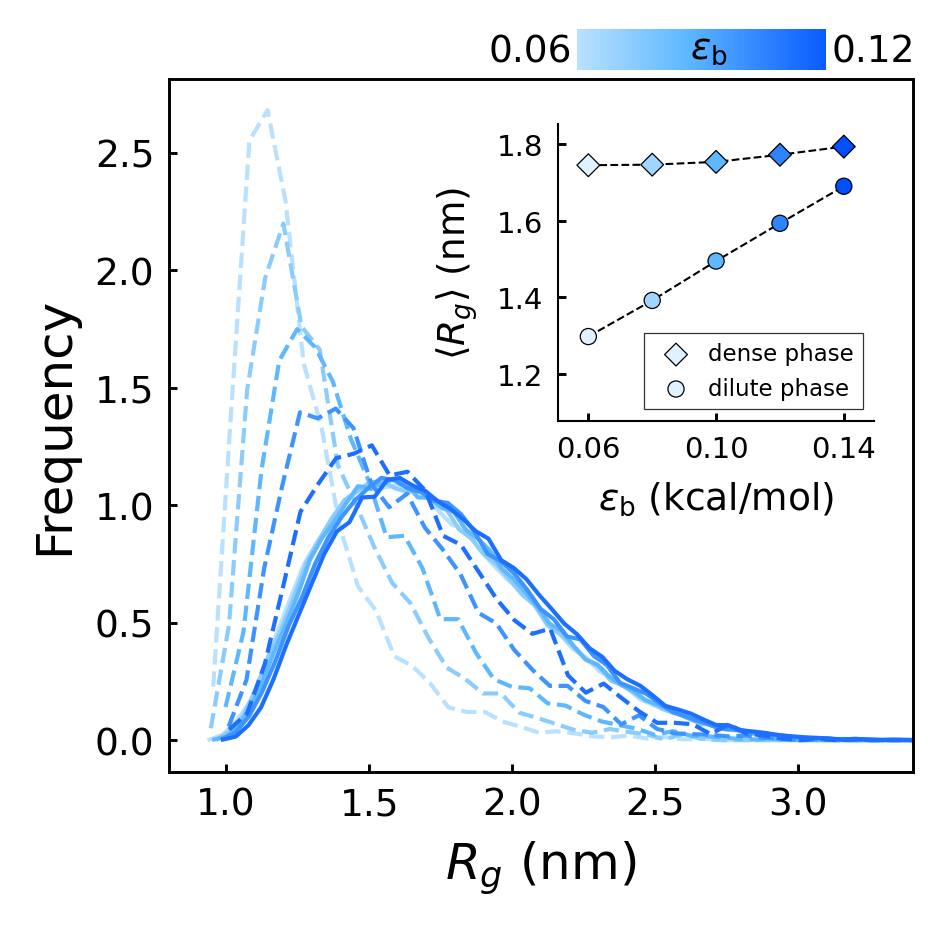

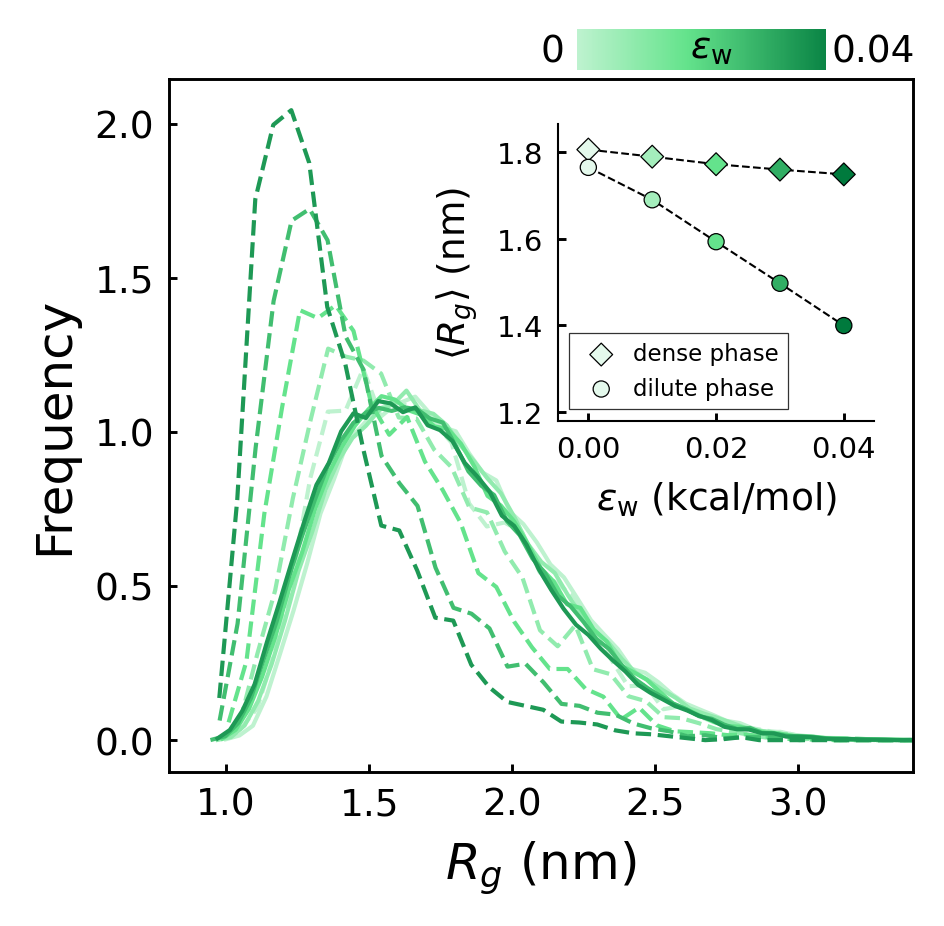

In [ ]:
## Fig.3 A and B

import sys, os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import MDAnalysis as mda
from matplotlib import cm, colors
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, Normalize

## Rg versus desolvation parameter
def rg2param(fixed_part):

    protein = 'poly50'
    fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)

    if fixed_part == 'e_w':
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256
        )
        param_list = np.arange(0.06, 0.16, 0.02)
        clist = cmap_full(np.linspace(0.15, 0.85, len(param_list)))
    if fixed_part == 'e_b':
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256
        )
        param_list = np.arange(0.00, 0.05, 0.01)
        clist = cmap_full(np.linspace(0.15, 0.85, len(param_list)))

    rg_cp, rg_dp = [], []
    for idx in range(len(param_list)):

        param = param_list[idx]
        if fixed_part == 'e_w':
            T_sim = 160
            folder = 'des_0.20_%.2f_0.02'%param
            label = '$\epsilon_{\mathregular{b}}$'%param
        if fixed_part == 'e_b':
            T_sim = 160
            folder = 'des_0.20_0.12_%.2f'%param
            label = '$\epsilon_{\mathregular{w}}$'%param
        datafile = 'data/%s/%s/%i_rg.npy'%(protein, folder, T_sim)

        ## Read slab simulation data
        if os.path.exists(datafile):
            rg = np.load(datafile)
        else:
            nres = 50
            neq = 300
            nskip = 2
            dcdfile = 'traj/%s/%s/%i/%i.dcd'%(protein, folder, T_sim, T_sim)
            gsdfile = 'traj/%s/%s/%i/%i.gsd'%(protein, folder, T_sim, T_sim)
            u = mda.Universe(gsdfile, dcdfile)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / nres)
            rg = []
            for frame in np.arange(neq, nlen, nskip):
                print(frame)
                ts = u.trajectory[frame]
                for i in range(nchains):
                    mol = u.select_atoms("index %i:%i"%(i * nres, (i + 1) * nres - 1))
                    mda.lib.mdamath.make_whole(mol)
                    rg.append((frame, mol.radius_of_gyration()))
            rg = np.array(rg)
            data = rg[:, 1]
            data[np.where(data > 10)] = None
            rg[:, 1] = data
            np.save('data/%s/%s/%i_rg.npy'%(protein, folder, T_sim), rg)

        hist, bins = np.histogram(rg[:, 1], bins=60, density=True)
        plt.plot(bins[:-1], hist, color=clist[idx],\
                 label=r'%s = %.2f kcal/mol'%(label, param), linestyle='-', lw=1)
        rg_cp.append(np.mean(rg[:, 1]))

        # Read single chain simulation data
        dcdfile = 'traj/%s/%s/%s_%i.dcd'%(protein, folder, protein, T_sim)
        gsdfile = 'traj/%s/%s/%s_%i.gsd'%(protein, folder, protein, T_sim)
        u = mda.Universe(gsdfile, dcdfile)
        at1 = u.select_atoms('all')
        nlen = len(u.trajectory)
        natoms = at1.n_atoms
        rg = np.zeros(nlen)
        for tdx, ts in enumerate(u.trajectory):
            mda.lib.mdamath.make_whole(at1)
            rg[tdx] = at1.radius_of_gyration()
        
        hist, bins = np.histogram(rg, bins=60, density=True)
        plt.plot(bins[:-1], hist, color=clist[idx], linestyle='--', lw=1)
        rg_dp.append(np.mean(rg))

    plt.xlabel(r'$R_g$ (nm)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim(0.8, 3.4)
    if fixed_part == 'e_b':
        plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(0.7)

    cbar_ax = fig.add_axes([0.55, 0.89, 0.26, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_full(np.linspace(0.15, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])

    if fixed_part == 'e_w':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{b}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.43, 1.025, '0.06', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.12', transform=ax.transAxes, fontsize=9, zorder=10)
    if fixed_part == 'e_b':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{w}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.50, 1.025, '0', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.04', transform=ax.transAxes, fontsize=9, zorder=10)

    axin = fig.add_axes([0.53, 0.5, 0.33, 0.33])
    axin.plot(param_list, rg_cp, '--k', lw=0.5, zorder=1)
    axin.plot(param_list, rg_dp, '--k', lw=0.5, zorder=1)
    axin.scatter(param_list, rg_cp, marker='D', c=param_list, cmap=cmap_full, s=15, label='dense phase', edgecolors='k', linewidths=0.3, zorder=10)
    axin.scatter(param_list, rg_dp, marker='o', c=param_list, cmap=cmap_full, s=15, label='dilute phase', edgecolors='k', linewidths=0.3, zorder=10)
    axin.set_xlabel(r'%s (kcal/mol)'%label, fontsize=9)
    axin.set_ylabel(r'$\langle R_g\rangle$ (nm)', fontsize=9)
    if fixed_part == 'e_w':
        leg = axin.legend(fontsize=5.5, loc='lower right', frameon=True, fancybox=False, edgecolor="black", handletextpad=0.4)
    if fixed_part == 'e_b':
        leg = axin.legend(fontsize=5.5, loc='lower left', frameon=True, fancybox=False, edgecolor="black", handletextpad=0.4)
    leg.get_frame().set_linewidth(0.3)
    axin.tick_params(labelsize=7, direction='in', length=2, width=0.7)
    axin.set_xticks(param_list[::2])
    param_range = max(param_list) - min(param_list)
    axin.set_xlim(min(param_list)-0.12*param_range, max(param_list)+0.12*param_range)
    axin.set_ylim(min(rg_dp)-0.22, max(rg_cp)+0.06)
    axin.yaxis.set_major_locator(MultipleLocator(0.2))
    axin.spines['top'].set_visible(False)
    axin.spines['right'].set_visible(False)
    axin.spines['left'].set_linewidth(0.5)
    axin.spines['bottom'].set_linewidth(0.5)

    plt.savefig(f"../../figures/rg/rg-{fixed_part}.svg", format="svg", bbox_inches='tight')
    plt.show()

# rg2temp()
rg2param('e_w')
rg2param('e_b')


/home/swalker/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


des_0.20_0.06_0.02


/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(sorted(unique_bonds)), 4)
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyobjects.py:600: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  guessed = np.asarray(guessed, dtype=np.bool)
/tmp/ipykernel_2778128/2096432451.py:22: RuntimeWarning: invalid value encountered in power
  return A *

des_0.20_0.14_0.02
des_0.20_0.12_0.00
des_0.20_0.12_0.04
des_0.20_0.12_0.02
des_0.20_0.08_0.02
des_0.20_0.12_0.01
des_0.20_0.10_0.02
des_0.20_0.12_0.03


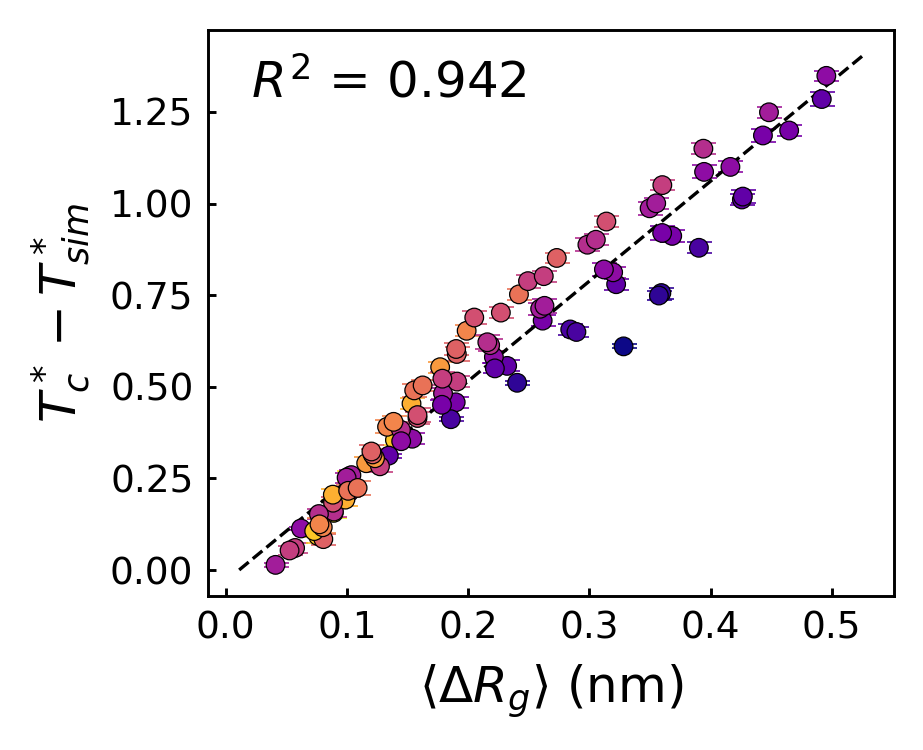

In [3]:
## Fig.3 C

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def deltarho2t(t, A, Tc):
    beta = 0.325
    return A * (Tc - t)**beta

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

protein = 'poly50'
delta_rg_list, delta_rg_std, tsim_list, tc_list, tc_err_list = [], [], [], [], []
folders = os.listdir('traj/' + protein)
nbins = 500
for folder in folders:
    param = folder.split('_')
    if len(param) == 1: # removing HPS model or not
        continue
    if len(param) != 1 and param[1] != '0.20':
        continue
    print(folder)
    rho_dense_list, rho_dilute_list, tsim_list_temp = [], [], []
    for temp in range(0, 1000, 10):
        param = folder.split('_')
        slab_dir = 'traj/{}/{}/{}/{}'.format(protein, folder, temp, temp)
        single_dir = '../rg/traj/tmp1/{}/{}/{}_{}'.format(protein, folder, protein, temp)
        if (not os.path.exists(f'{slab_dir}.gsd')) or (not os.path.exists(f'{single_dir}.gsd')):
            continue

        # calculate phase density
        rho_data = f'data/{protein}/{folder}/{temp}_dp.npy'
        if os.path.exists(rho_data):
            rhoave = np.load(rho_data)
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(300, nlen, 2):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(rho_data, rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue

        tsim_list_temp.append(temp)
        rho_dense_list.append(rho_hd)
        rho_dilute_list.append(rho_ld)

        # calculate dense phase rg
        data_slab_rg = 'data/{}/{}/{}_rg.npy'.format(protein, folder, temp)
        if os.path.exists(data_slab_rg):
            rg = np.load(data_slab_rg)
        else:
            nres = 50
            neq = 300
            nskip = 2
            u = mda.Universe(f'{slab_dir}.gsd', f'{slab_dir}.dcd')
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / nres)
            rg = []
            for frame in np.arange(neq, nlen, nskip):
                ts = u.trajectory[frame]
                for i in range(nchains):
                    mol = u.select_atoms("index %i:%i"%(i * nres, (i + 1) * nres - 1))
                    mda.lib.mdamath.make_whole(mol)
                    rg.append((frame, mol.radius_of_gyration()))
            rg = np.array(rg)
            data = rg[:, 1]
            data[np.where(data > 10)] = None
            rg[:, 1] = data
            np.save(data_slab_rg, rg)

        hist, bins = np.histogram(rg[:, 1], bins=50, density=True)
        rg_dense = np.mean(rg[:, 1])
        rg_dense_std = np.std(rg[:, 1])

        # calculate dilute phase rg
        u = mda.Universe(f'{single_dir}.gsd', f'{single_dir}.dcd')
        at1 = u.select_atoms('all')
        nlen = len(u.trajectory)
        natoms = at1.n_atoms
        rg = np.zeros(nlen)
        for tdx, ts in enumerate(u.trajectory):
            mda.lib.mdamath.make_whole(at1)
            rg[tdx] = at1.radius_of_gyration()
        
        hist, bins = np.histogram(rg, bins=50, density=True)
        rg_dilute = np.mean(rg)
        rg_dilute_std = np.std(rg)

        delta_rg_list.append(rg_dense - rg_dilute)
        delta_rg_std.append(math.sqrt(rg_dense_std**2 + rg_dilute_std**2))
        
    delta_rho = np.array(rho_dense_list) - np.array(rho_dilute_list)
    T_prods = np.array(tsim_list_temp)
    param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
    A, T_c = param[0]

    popt, pcov = curve_fit(deltarho2t, T_prods, delta_rho, p0 = [200, T_c])
    Tc_val = popt[1]
    Tc_err = np.sqrt(np.diag(pcov))[1]

    tc_list.extend([Tc_val]*len(tsim_list_temp))
    tsim_list.extend(tsim_list_temp)
    tc_err_list.extend([Tc_err]*len(tsim_list_temp))

delta_t_list = np.array(tc_list) - np.array(tsim_list)

fig, ax = plt.subplots(1, 1, figsize=[3.1, 2.6], facecolor='w', dpi=300)

cmap = cm.plasma
norm = plt.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))

for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    plt.errorbar(x=rg, y=t*0.009935, yerr=tc_std*0.009935, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
plt.scatter(delta_rg_list, delta_t_list*0.009935, s=20, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))

z = np.polyfit(delta_rg_list, delta_t_list, 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list)[0, 1]
R2 = r2_score(delta_t_list, p(delta_rg_list))

delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.03, max(delta_rg_list)+0.03, 10)
plt.plot(delta_rg_fit_range, p(delta_rg_fit_range)*0.009935, 'k--', lw=0.8)
plt.text(min(delta_rg_list)-0.02, (max(delta_t_list)-6)*0.009935, r'$R^2$ = %.3f'%R2, fontsize=12)

plt.xlabel(r'$\langle \Delta R_g \rangle$ (nm)', fontsize=12)
plt.ylabel(r'$T_c^* - T_{sim}^*$', fontsize=12)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
for spine in ax.spines.values():
    spine.set_linewidth(0.7)

# norm = mpl.colors.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# dv = make_axes_locatable(ax)
# cb = fig.colorbar(sm, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08))
# cb.set_label(label='Temperature (K)', size=11)
# cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

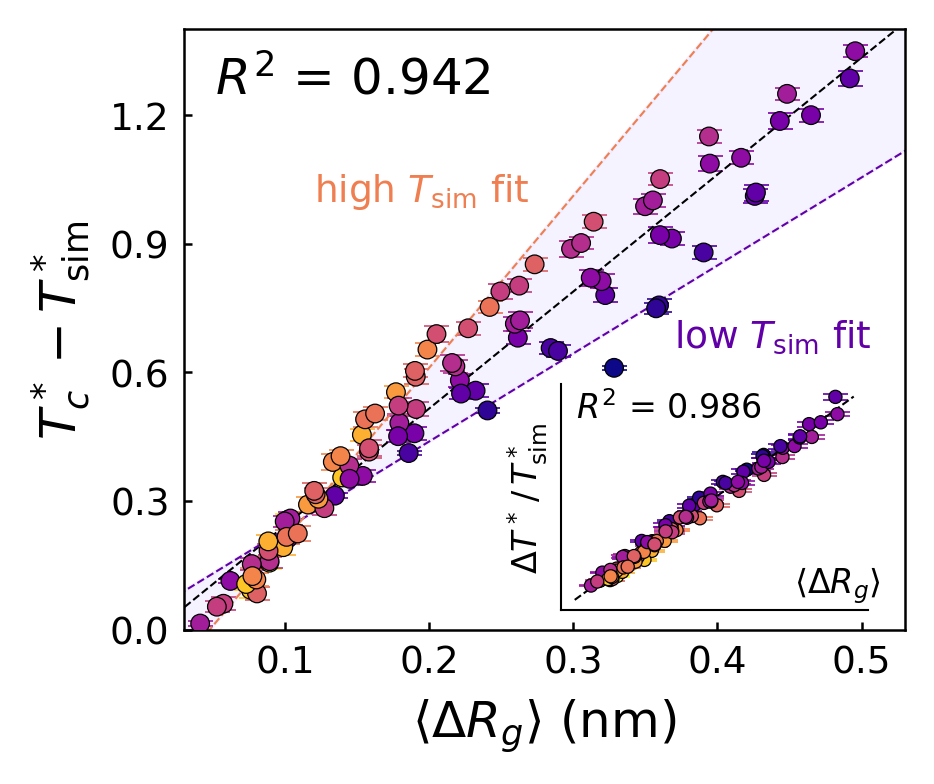

In [40]:
fig, ax = plt.subplots(1, 1, figsize=[3.1, 2.6], facecolor='w', dpi=300)

cmap = cm.plasma
norm = plt.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))

for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    plt.errorbar(x=rg, y=t*0.009935, yerr=tc_std*0.009935, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
plt.scatter(delta_rg_list, delta_t_list*0.009935, s=20, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))

z = np.polyfit(delta_rg_list, delta_t_list, 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list)[0, 1]
R2 = r2_score(delta_t_list, p(delta_rg_list))

mask_low = np.where(np.array(tsim_list)*0.009935<1.2)
z_low = np.polyfit(np.array(delta_rg_list)[mask_low], np.array(delta_t_list)[mask_low], 1)
p_low = np.poly1d(z_low)

mask_high = np.where(np.array(tsim_list)*0.009935>2.4)
z_high = np.polyfit(np.array(delta_rg_list)[mask_high], np.array(delta_t_list)[mask_high], 1)
p_high = np.poly1d(z_high)

delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.1, max(delta_rg_list)+0.1, 1000)
fit_line = p(delta_rg_fit_range)*0.009935
fit_line_low = p_low(delta_rg_fit_range)*0.009935
fit_line_high = p_high(delta_rg_fit_range)*0.009935
plt.plot(delta_rg_fit_range, fit_line, 'k--', lw=0.5)
plt.plot(delta_rg_fit_range, fit_line_low, ls='--', lw=0.5, color=cmap(norm(min(tsim_list)*1.3)))
plt.plot(delta_rg_fit_range, fit_line_high, ls='--', lw=0.5, color=cmap(norm(max(tsim_list)*0.8)))
plt.fill_between(delta_rg_fit_range, fit_line_low, fit_line_high, color='#EDE8FF', alpha=0.5)
plt.text(min(delta_rg_list)+0.01, (max(delta_t_list)-10)*0.009935, r'$R^2$ = %.3f'%R2, fontsize=12)
# plt.text(0.28, 0.43, r'low $T_\mathregular{sim}$ fit', fontsize=9, color=cmap(norm(min(tsim_list)*1.3)))
plt.text(0.37, 0.66, r'low $T_\mathregular{sim}$ fit', fontsize=9, color=cmap(norm(min(tsim_list)*1.3)))
plt.text(0.12, 1, r'high $T_\mathregular{sim}$ fit', fontsize=9, color=cmap(norm(max(tsim_list)*0.8)))

plt.xlim(0.03, 0.53)
plt.ylim(0, 1.4)
plt.xlabel(r'$\langle \Delta R_g \rangle$ (nm)', fontsize=12)
plt.ylabel(r'$T_c^* - T_\mathregular{sim}^*$', fontsize=12)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.6)
plt.yticks([0, 0.3, 0.6, 0.9, 1.2])
for spine in ax.spines.values():
    spine.set_linewidth(0.6)

axin = fig.add_axes([0.53, 0.135, 0.33, 0.29])
for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    axin.errorbar(x=rg, y=t/tsim, yerr=tc_std/tsim, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
axin.scatter(delta_rg_list, delta_t_list/np.array(tsim_list), s=10, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))
z = np.polyfit(delta_rg_list, delta_t_list/np.array(tsim_list), 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list/np.array(tsim_list))[0, 1]
R2 = r2_score(delta_t_list/np.array(tsim_list), p(delta_rg_list))
delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.03, max(delta_rg_list)+0.03, 10)
axin.plot(delta_rg_fit_range, p(delta_rg_fit_range), 'k--', lw=0.5)
axin.set_xticks([])
axin.set_yticks([])
# axin.set_ylabel(r'$(T_c^*-T_\mathregular{sim}^*)\,/\,T_\mathregular{sim}^*$', fontsize=7, labelpad=-1)
axin.set_ylabel(r'$\Delta T^*\,/\,T_\mathregular{sim}^*$', fontsize=8, labelpad=-1)
axin.text(0.76, 0.08, r'$\langle\Delta R_g\rangle$', fontsize=8, transform=axin.transAxes)
axin.text(0.05, 0.85, r'$R^2$ = %.3f'%R2, fontsize=8, transform=axin.transAxes)
axin.spines['top'].set_visible(False)
axin.spines['right'].set_visible(False)
axin.spines['left'].set_linewidth(0.5)
axin.spines['bottom'].set_linewidth(0.5)

# plt.tight_layout()
plt.savefig(f"../../figures/rg/deltat2deltarg.svg", format="svg", bbox_inches='tight')
plt.show()

des_0.20_0.06_0.02


/tmp/ipykernel_1710040/2360557632.py:13: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


des_0.20_0.14_0.02
des_0.20_0.12_0.00
des_0.20_0.12_0.04
des_0.20_0.12_0.02
des_0.20_0.08_0.02
des_0.20_0.12_0.01
des_0.20_0.10_0.02
des_0.20_0.12_0.03
 
0.4088 x + 7.374


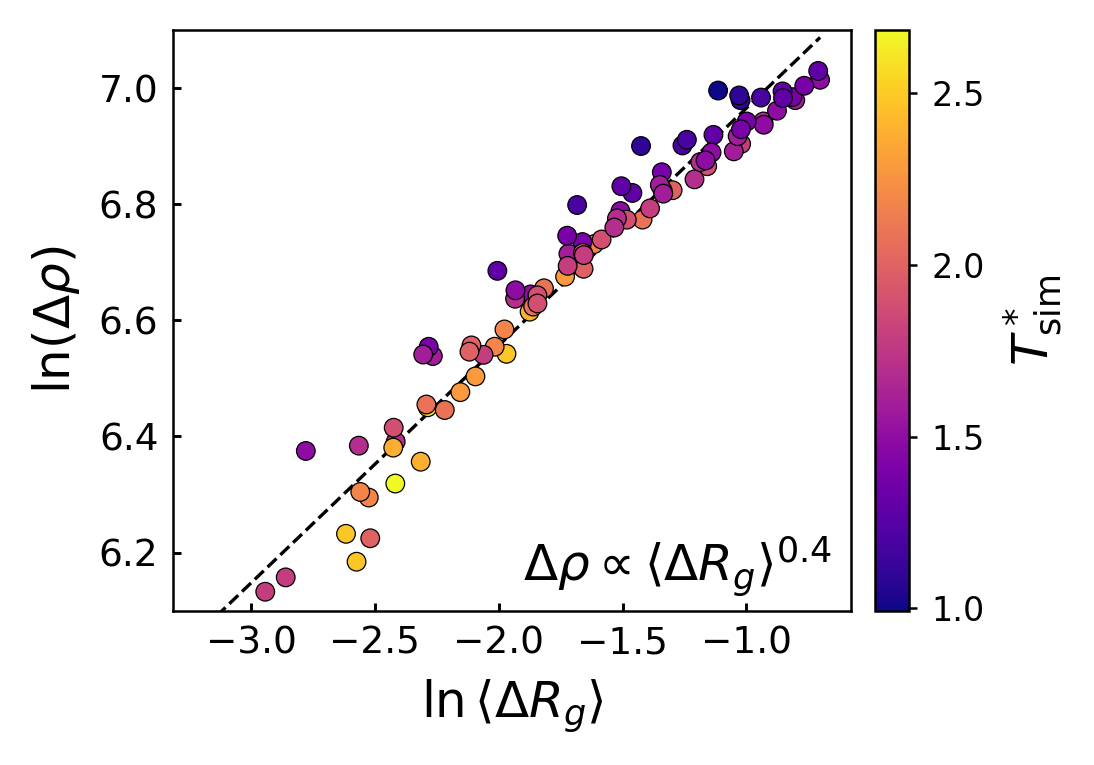

In [5]:
## Fig.3 D
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import matplotlib.cm as cm
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1 import make_axes_locatable

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

protein = 'poly50'

## Calculate density of dilute and condensed phase
RHO_H, RHO_L, RG_H, RG_L, T, T_SCALE = [], [], [], [], [], []
folders = os.listdir('traj/' + protein)
for folder in folders:
    param = folder.split('_')
    if len(param) == 1: # removing HPS model or not
        continue
    if len(param) != 1 and param[1] != '0.20':
        continue
    print(folder)
    data_folder = 'data/' + protein + '/' + folder + '/'
    rho_h_list, rho_l_list, t_list = [], [], []
    for temp in range(0, 1000, 10):
        simulation_T = str(temp)

        traj_folder = 'traj/' + protein + '/' + folder + '/' + simulation_T + '/'
        if not os.path.exists(traj_folder):
            continue
        u = mda.Universe(traj_folder + simulation_T + '.gsd',
                         traj_folder + simulation_T + '.dcd', pbc=True)
        at = u.select_atoms('all')
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        mass = u.atoms.masses
        name = u.atoms.names
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        nres = 168
        dz = lenz / nbins
        axisz = np.linspace(zmin, zmax, nbins)

        ## obtain the density data
        if os.path.exists(data_folder + simulation_T + '_dp.npy'):
            rhoave = np.load(data_folder + simulation_T + '_dp.npy')
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(300, nlen, 2):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(data_folder + simulation_T + '_dp.npy', rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue

        rho_h_list.append(rho_hd)
        rho_l_list.append(rho_ld)
        t_list.append(temp)

        RHO_H.append(rho_hd)
        RHO_L.append(rho_ld)

        ## obtain the rg data
        datafile = 'data/%s/%s/%i_rg.npy'%(protein, folder, temp)
        if os.path.exists(datafile):
            rg = np.load(datafile)
        else:
            nres = 50
            neq = 300
            nskip = 2
            dcdfile = 'traj/%s/%s/%i/%i.dcd'%(protein, folder, temp, temp)
            gsdfile = 'traj/%s/%s/%i/%i.gsd'%(protein, folder, temp, temp)
            u = mda.Universe(gsdfile, dcdfile)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / nres)
            rg = []
            for frame in np.arange(neq, nlen, nskip):
                ts = u.trajectory[frame]
                for i in range(nchains):
                    mol = u.select_atoms("index %i:%i"%(i * nres, (i + 1) * nres - 1))
                    mda.lib.mdamath.make_whole(mol)
                    rg.append((frame, mol.radius_of_gyration()))
            rg = np.array(rg)
            data = rg[:, 1]
            data[np.where(data > 10)] = None
            rg[:, 1] = data
            np.save(datafile, rg)
        
        RG_H.append(np.mean(rg[:, 1]))

        datafile = 'data/%s/%s/%i_rg_single.npy'%(protein, folder, temp)
        if os.path.exists(datafile):
            rg_single = np.load(datafile)
        else:
            dcdfile = '../rg/traj/%s/%s/%s_%i.dcd'%(protein, folder, protein, temp)
            gsdfile = '../rg/traj/%s/%s/%s_%i.gsd'%(protein, folder, protein, temp)
            u = mda.Universe(gsdfile, dcdfile)
            at = u.select_atoms('all')
            nlen = len(u.trajectory)
            natoms = at.n_atoms
            rg_single = np.zeros(nlen)
            for tdx, ts in enumerate(u.trajectory):
                mda.lib.mdamath.make_whole(at)
                rg_single[tdx] = at.radius_of_gyration()
            np.save(datafile, rg_single)
        
        RG_L.append(np.mean(rg_single))

        T.append(temp)
    
    delta_rho = np.array(rho_h_list) - np.array(rho_l_list)
    rho_ave = (np.array(rho_h_list) - np.array(rho_l_list)) / 2
    T_prods = np.array(t_list)
    param = leastsq(err_Tc, [100, 300], args=(T_prods, delta_rho))
    A, T_c = param[0]

    T_SCALE.extend(np.array(t_list) / T_c)

delta_rg = np.array(RG_H) - np.array(RG_L)
delta_rho = (np.array(RHO_H) - np.array(RHO_L))

fig, ax = plt.subplots(1, 1, figsize=[3.75, 2.65], facecolor='w', dpi=300)

scatter = plt.scatter(np.log(delta_rg), np.log(delta_rho), s=20, c=np.array(T)*0.009935, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=10)

z = np.polyfit(np.log(delta_rg), np.log(delta_rho), 1)
p = np.poly1d(z)
print(p)
R2 = r2_score(np.log(delta_rho), p(np.log(delta_rg)))

xaxis_range = np.linspace(min(np.log(delta_rg)), max(np.log(delta_rg)), 10)
plt.plot(xaxis_range, p(xaxis_range), 'k--', lw = 0.8)
plt.text(max(np.log(delta_rg))-1.2, min(np.log(delta_rho))+0.4, r'$\Delta\rho \propto \langle \Delta R_g\rangle^{0.4}$', fontsize=12)

plt.xlabel(r'$\ln \langle \Delta R_g\rangle$', fontsize=12)
plt.ylabel(r'$\ln (\Delta \rho)$', fontsize=12)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
plt.yticks([6.2, 6.4, 6.6, 6.8, 7.0])
plt.ylim(6.1, 7.1)
for spine in ax.spines.values():
    spine.set_linewidth(0.6)

dv = make_axes_locatable(ax)
# cb = fig.colorbar(mappable=scatter, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08), ticks=[100, 130, 160, 190, 220, 250])
cb = fig.colorbar(mappable=scatter, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08), ticks=[1, 1.5, 2, 2.5])
cb.set_label(label=r'$T_\mathregular{sim}^*$', size=12)
cb.ax.tick_params(labelsize=8, length=2, width=0.6)
for spine in cb.ax.spines.values():
    spine.set_linewidth(0.6)

plt.tight_layout()
plt.savefig(f"../../figures/rg/deltarho2deltarg.svg", format="svg", bbox_inches='tight')
plt.show()